# Machine Problem  
Nathaniel Cruel and Renzo Virtucio  
Department of Computer Science, University of the Philippines Diliman  
CS 180: Artificial Intelligence  
Professor Carlo Raquel  
June 15, 2021
***

## Introduction to the Problem
## Rationale
## Objective

## Methodology

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix

# Create dataframe
students_math = pd.read_csv('student/student-mat.csv', delimiter=';', header=0)
display(students_math)

The dataset underwent PREPROCESSING before analysis. First, binary attributes were encoded to categorical data...

Lastly, a new column/attribute called QUALITY was added to the dataset. The value of this attribute depends on the value of attribute G3. If G3 is GREATER THAN OR EQUAL TO 12 (60% of 20, the highest possible value of G3), then QUALITY is set to 1 (HIGH grade). If G3 is greater than 0 but less than 12, then QUALITY is 0 (LOW grade).

This binary attribute would serve as the target output in the analysis, as it ideal for the Support Vector Machine (SVM) algorithm.

In [ ]:
## PREPROCESSING ##
# Encoding binary attributes
students_math.school = students_math.school.map({"GP":0, "MS":1})
students_math.sex = students_math.sex.map({"F":0, "M":1})
students_math.address = students_math.address.map({"U":0, "R":1})
students_math.famsize = students_math.famsize.map({"LE3":0, "GT3":1})
students_math.Pstatus = students_math.Pstatus.map({"T":0, "A":1})
students_math.schoolsup = students_math.schoolsup.map({"yes":0, "no":1})
students_math.famsup = students_math.famsup.map({"yes":0, "no":1})
students_math.paid = students_math.paid.map({"yes":0, "no":1})
students_math.activities = students_math.activities.map({"yes":0, "no":1})
students_math.nursery = students_math.nursery.map({"yes":0, "no":1})
students_math.higher = students_math.higher.map({"yes":0, "no":1})
students_math.internet = students_math.internet.map({"yes":0, "no":1})
students_math.romantic = students_math.romantic.map({"yes":0, "no":1})

# Encoding nominal attributes
job_types = ["teacher", "health", "services", "at_home", "other"]
reason_types = ["home", "reputation", "course", "other"]
guardian_types = ["mother", "father", "other"]
Mjob_dum = pd.get_dummies(students_math['Mjob'], prefix='Mjob')
Fjob_dum = pd.get_dummies(students_math['Fjob'], prefix='Fjob')
reason_dum = pd.get_dummies(students_math['reason'], prefix='reason')
guardian_dum = pd.get_dummies(students_math['guardian'], prefix='guardian')

students_math = pd.concat([students_math, Mjob_dum, Fjob_dum, reason_dum, guardian_dum], axis=1)
students_math.drop(['Mjob', 'Fjob', 'reason', 'guardian'], axis=1, inplace=True)
students_math

# Add a column describing if G3 (final grade) is high or low
# High = 12-20 (60% of 20 and above)
# Low = 0-11 (below 60% of 20)
students_math["quality"] = (students_math.G3 >= 12).map({True: 1, False: 0})
display(students_math)

To examine the correlation levels of the attributes with respect to one another and with respect to the target variable, QUALITY, a CORRELATION MATRIX WITH HEATMAP is plotted. The algorithm for the plotting the correlation matrix and the correlation matrix itself are shown below.

In [ ]:
#Determine correlation per two variables
corrmat = students_math.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(47,47))
plt.title("Figure 1. Correlation Matrix Heatmap of Student Performance Dataset")

# Plot heat map
g=sns.heatmap(students_math[top_corr_features].corr(),annot=True,cmap="RdYlGn")

The correlation heatmap above shows that the attributes G1 (grade in 1st period), G2 (grade in 2nd period), and G3 (final grade), are HIGHLY CORRELATED to the target output, QUALITY. Later on, these attributes are to be removed for comparison in the analysis.

In [ ]:
# Define X and y for testing and training
y = students_math['quality']
X = students_math.drop('quality', axis=1)
print(X.shape, y.shape)

In [ ]:
# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Observe that some variables have a very large VIF, signalling multicollinearity
calculate_vif(X)

In [ ]:
# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=46)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
display(X)
# Observe that the Variance Inflation Factor are low and uniform (1.0)
calculate_vif(X)  


In [ ]:
# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC()
model.fit(X_train, y_train)

# Compute model predictions
model_predictions = model.predict(X_test)
# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, model_predictions))

In [ ]:
# Use GridSearchCV to optimize the parameters of SVC
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ('linear', 'rbf', 'poly', 'sigmoid')} 

# Create grid object
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
  
# Fitting the model for grid search
grid.fit(X_train, y_train)

In [ ]:
# Print best parameter after tuning
print(grid.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

In [ ]:
# Compute grid predictions
grid_predictions = grid.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, grid_predictions))

As shown in the CORRELATION MATRIX WITH HEATMAP in Figure 1. Correlation Matrix Heatmap of Student Performance Dataset, attributes G1-G3 (grade in 1st period, grade in 2nd period, final grade - respectively) are HIGHLY CORRELATED to the target output, QUALITY. 

Thus, we would like to show below the results of SVM if these 3 attributes are to be REMOVED for analysis. This is for comparison purposes, which shall be discussed in the DATA AND ANALYSIS section.

In [ ]:
# Without G1 - G3

# Define X and y for testing and training
y = students_math['quality']
X = students_math.drop(['quality', 'G1', 'G2', 'G3'], axis=1)
print(X.shape, y.shape)

<ipython-input-27-de4201d181fe>:12: RuntimeWarning: divide by zero encountered in double_scalars
  vif = round(1/(1-r_squared),2)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,-0.696420,-0.543569,-0.830530,2.943415,-0.903290,0.238887,2.663675,0.812153,3.429692,-0.306524,...,0.308552,-0.152013,-0.392782,1.273972,0.571486,0.554223,9.858020e-15,3.351221e-16,2.662655e-16,5.280589e-16
1,1.587596,-2.333203,1.025253,1.215612,1.691928,-0.245996,-0.378067,-0.520318,-0.521157,-2.210893,...,1.253466,0.404979,0.620591,-0.004250,0.707072,-0.082017,-2.119636e-15,3.981261e-15,2.762979e-15,1.324809e-15
2,1.854501,-0.992269,-0.440001,0.336069,-0.960559,-1.259283,-1.459209,3.490023,0.634674,-0.604033,...,0.267138,-0.787872,-1.901515,0.239848,-0.275176,-0.106434,1.054945e-16,1.211967e-16,1.656224e-15,6.388961e-16
3,-2.903551,-0.834788,1.208169,-0.289667,-1.000191,-0.526718,-0.165848,1.593953,-1.732435,-0.949278,...,0.023089,-0.550515,0.075234,-0.572952,0.539894,0.290283,8.431003e-16,-4.406806e-17,1.219625e-16,1.880498e-15
4,-0.545183,-1.688027,0.805115,-1.191339,2.276270,0.940360,1.259853,1.096291,-0.458430,-1.033753,...,-0.566795,-0.509053,-0.240071,0.025887,-0.150104,0.207301,-2.067710e-15,5.026779e-16,1.016011e-15,-1.494988e-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,3.638757,3.817039,2.060802,-0.964932,-2.112953,-0.889352,-0.052341,-1.538361,1.506659,-1.209759,...,1.137273,-0.537142,-0.748258,-0.946977,-0.372792,-0.181386,1.742375e-16,1.575457e-16,-3.454375e-16,-2.072128e-16
391,2.571985,3.255018,-0.277192,1.246593,-0.466258,-0.516077,-0.748857,0.638291,-1.247177,0.921436,...,0.285841,0.543934,-0.449021,-0.535491,0.792916,0.759661,1.989066e-16,2.626022e-16,2.125974e-17,8.651129e-17
392,6.754430,0.754896,0.699553,-0.992947,0.029601,0.965098,1.181412,-3.206676,0.887722,-0.832699,...,0.782365,-0.373543,-0.108066,-0.135036,0.132414,-0.328613,2.995406e-16,-2.618200e-16,3.480558e-16,4.090955e-17
393,3.214061,1.891269,-1.566406,1.671802,0.196696,1.165926,-0.110365,-0.548587,-0.141568,0.912515,...,-0.051045,-1.313618,0.268778,0.420272,-0.198745,0.643708,7.199392e-16,3.084748e-17,-4.075197e-17,5.615502e-16


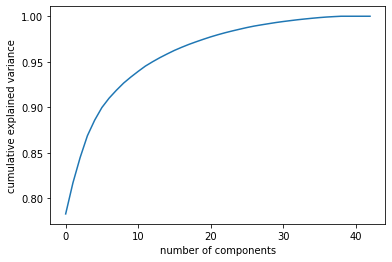

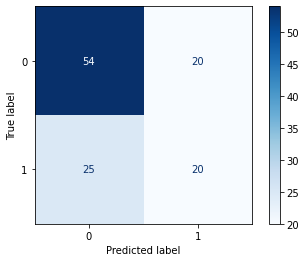

              precision    recall  f1-score   support

           0       0.68      0.73      0.71        74
           1       0.50      0.44      0.47        45

    accuracy                           0.62       119
   macro avg       0.59      0.59      0.59       119
weighted avg       0.61      0.62      0.62       119

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
SVC(C=0.1, gamma=1, kernel='poly')


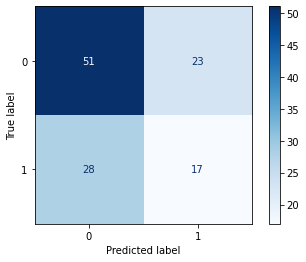

              precision    recall  f1-score   support

           0       0.65      0.69      0.67        74
           1       0.42      0.38      0.40        45

    accuracy                           0.57       119
   macro avg       0.54      0.53      0.53       119
weighted avg       0.56      0.57      0.57       119



In [27]:
# Without G1 - G3

# Compute for the Variance Inflation Factor of each variable to identify
# multicollinearity
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y,x).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)

# Observe that some variables have a very large VIF, signalling multicollinearity
calculate_vif(X)

# To address multicollinearity, we utilize Principal Component Analysis.
# Determine the optimal number of components based on the cumulative
# explained variance.
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# Standardize the data
X = StandardScaler().fit_transform(X)
# PCA Projection
pca = PCA(n_components=43)  
principalComponents = pca.fit_transform(X)
X = pd.DataFrame(data = principalComponents)

# Display new dataframe
display(X)
# Observe that the Variance Inflation Factor are low and uniform (1.0)
calculate_vif(X)  


# Split the data for testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Fitting a support vector machine
model = SVC()
model.fit(X_train, y_train)

# Compute model predictions
model_predictions = model.predict(X_test)
# Plot confusion matrix
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 
# Print classification report
print(classification_report(y_test, model_predictions))

# Use GridSearchCV to optimize the parameters of SVC
# Defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ('linear', 'rbf', 'poly', 'sigmoid')} 

# Create grid object
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
  
# Fitting the model for grid search
grid.fit(X_train, y_train)

# Print best parameter after tuning
print(grid.best_params_)
 
# Print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

# Compute grid predictions
grid_predictions = grid.predict(X_test)

# Plot confusion matrix
plot_confusion_matrix(grid, X_test, y_test, cmap=plt.cm.Blues)  
plt.show() 

# Print classification report
print(classification_report(y_test, grid_predictions))

## Data and Analysis

## Conclusion

## Individual Contributions